# Load libraries and set device up

In [1]:
import seaborn           as sns
import numpy             as np
import matplotlib.pyplot as plt
import torch
import json
import os

import libraries.model   as clm
import libraries.dataset as cld

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()

# Define parameters

In [2]:
target = 'EPA'
folder = 'MP-EPA'

r_folder = f'models/{folder}'
t_folder = f'targets/{folder}'

# Generate or load graph database for training

Reference dataset

In [3]:
files_names = {
    'r_dataset_std_name':      f'{r_folder}/train_dataset_std.pt',
    'r_std_parameters_name':   f'{r_folder}/standardized_parameters.json',
    'r_uncertainty_data_name': f'{r_folder}/uncertainty_data.json',
    'model_name':              f'{r_folder}/model.pt',
    'dt_param_name':           f'{r_folder}/dataset_parameters.json',
    't_dataset_name':          f'{t_folder}/dataset.pt'
}
cld.save_json(files_names, f'{t_folder}/files_names.json')

In [4]:
# Load the standardized dataset, with corresponding labels and parameters
temp_r_dataset_std = torch.load(files_names['r_dataset_std_name'], weights_only=False)

# Load uncertainty data
r_uncertainty_data = cld.load_json(files_names['r_uncertainty_data_name'])

# Check all reference data in uncertainty_data
r_dataset_std = [data for data in temp_r_dataset_std if data.label in r_uncertainty_data['uncertainty_values'].keys()]

# Load std parameters data
r_std_parameters = cld.load_json(files_names['r_std_parameters_name'])

# Load dataset parameters data
r_dataset_parameters = cld.load_json(files_names['dt_param_name'])

# Defining target factor
target_factor = r_std_parameters['target_std'] / r_std_parameters['scale']

Prediciton dataset

In [5]:
if not os.path.exists(files_names['t_dataset_name']):
    # Generate data
    cld.generate_dataset(t_folder,
                         targets=['bandgap'],
                         data_folder=t_folder)

# Load the standardized dataset, with corresponding labels and parameters
t_dataset = torch.load(files_names['t_dataset_name'], weights_only=False)

# Determine the index for the desired property
target_idx = [idx for idx, t in enumerate(r_dataset_parameters['target']) if t == target][0]

# Select the target we want
for data in t_dataset:
    data.y = torch.tensor([data.y[target_idx]], dtype=torch.float)

# Select the target we want
ground_truths = np.array([data.y.item() for data in t_dataset])

# Standardize the dataset with
t_dataset_std = cld.standardize_dataset_from_keys(t_dataset, r_std_parameters)
del t_dataset

# Load model and make predictions

In [6]:
model = clm.load_model(r_dataset_std[0].num_node_features, 0, device, model_name=files_names['model_name'], purpose='eval')
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 32)
    (conv2): GraphConv(32, 32)
    (lin1): Linear(in_features=32, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [11]:
import importlib
importlib.reload(clm)

<module 'libraries.model' from '/home/claudio/cibran/Work/UPC/CLUE/libraries/model.py'>

In [33]:
# Compute predictions
predictions, uncertainties, are_interpolated = clm.make_predictions(r_dataset_std[:500],
                                                                    t_dataset_std[:100],
                                                                    model, r_std_parameters, r_uncertainty_data)

In [34]:
ground_truths = np.array([data.y.item() for data in t_dataset[:100]])

In [35]:
r_uncertainty_data

{'uncertainty_values': {'LaNb3O9-C2-m': 325.03551710951115,
  'MnPdAu2-Immm': 1043.1220594774463,
  'Pr2MgS4-I-42d': 521.180203093169,
  'CsVP2O7-P2_1-c': 401.24206460821415,
  'Na3MgNbSi2SO12-Cc': 420.78230918752934,
  'Ba2DyBiO6-Pn-3': 462.40097965109135,
  'MnVSbO6-Pbcn': 400.4761480222919,
  'K3Zr6BeCl15-C2-c': 520.0459276567676,
  'NaAl6Fe3Si6B3H3O30F-R3m': 390.62821163046146,
  'Sb(IF3)2-P-1': 629.813425673125,
  'LiVPH4O7-Cmce': 398.62444366323734,
  'AlP3NO10-P2-c': 427.4573866258838,
  'K17Fe5O16-Cm': 515.7751394640186,
  'Cs3SbI6-Fm-3m': 476.94760574209477,
  'Li3PS4-Pnma': 388.5334936510303,
  'Sr15Ti23O61-P2-m': 231.50333846914555,
  'MgGe2WO6-P2_1-c': 427.2648955713489,
  'LiCuSbO4-P2_1': 491.1899458299854,
  'Cu2H12C4Br3N-Pnma': 460.02230514395023,
  'Cs4Fe(MoO4)3-Cc': 427.89199413168217,
  'KSmS2O9-P2_1-c': 469.7811697851398,
  'LiFePO4-P2': 404.0696016679981,
  'Ba2SrI6-P4_2-mnm': 427.7141615282276,
  'Na14Mg4Si7Sn4S5O48-P1': 450.3443075548389,
  'Sr2SnO4-Pccn': 148.645

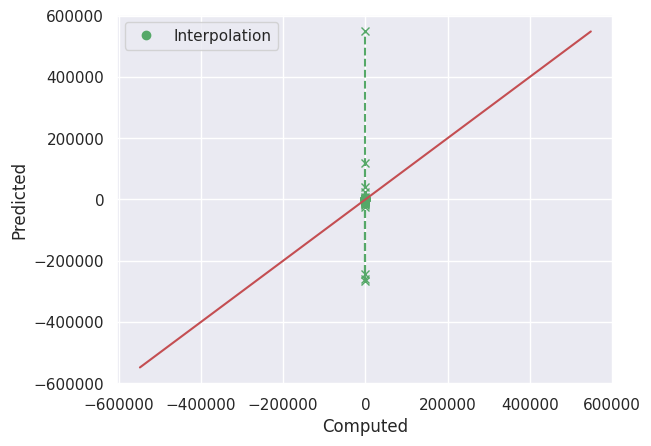

In [36]:
# Extract and plot interpolation data
xpred_interp = ground_truths
ypred_interp = predictions
yerr_interp = uncertainties

plt.plot(xpred_interp, ypred_interp, 'og', label='Interpolation')  # Predictions
plt.plot(xpred_interp, ypred_interp + yerr_interp, 'xg')           # Corrected values
for x, y, err in zip(xpred_interp, ypred_interp, yerr_interp):
    plt.plot([x, x], [y, y + err], 'g--')  # Vertical line

# Add identity line and labels
_min_, _max_ = cld.get_min_max(
    ground_truths + np.abs(uncertainties),
    ground_truths - np.abs(uncertainties),
    predictions
)
plt.plot([_min_, _max_], [_min_, _max_], '-r')  # Identity line
plt.xlabel('Computed')
plt.ylabel('Predicted')
plt.legend(loc='best')
plt.show()

In [7]:
# Compute predictions
predictions, uncertainties, are_interpolated = clm.make_predictions(r_dataset_std,
                                                                    t_dataset_std,
                                                                    model, r_std_parameters, r_uncertainty_data)

# Plot predictions

In [19]:
# Extract and plot interpolation data
xpred_interp = ground_truths[are_interpolated]
ypred_interp = predictions[are_interpolated]
yerr_interp = uncertainties[are_interpolated]

plt.plot(xpred_interp, ypred_interp, 'og', label='Interpolation')  # Predictions
plt.plot(xpred_interp, ypred_interp + yerr_interp, 'xg')           # Corrected values
for x, y, err in zip(xpred_interp, ypred_interp, yerr_interp):
    plt.plot([x, x], [y, y + err], 'g--')  # Vertical line

# Extract and plot extrapolation data
xpred_extra = ground_truths[~are_interpolated]
ypred_extra = predictions[~are_interpolated]
yerr_extra = uncertainties[~are_interpolated]

plt.plot(xpred_extra, ypred_extra, 'ob', label='Extrapolation')    # Predictions
plt.plot(xpred_extra, ypred_extra + yerr_extra, 'xb')             # Corrected values
for x, y, err in zip(xpred_extra, ypred_extra, yerr_extra):
    plt.plot([x, x], [y, y + err], 'b--')  # Vertical line

# Add identity line and labels
_min_, _max_ = cld.get_min_max(
    ground_truths + np.abs(uncertainties),
    ground_truths - np.abs(uncertainties),
    predictions
)
plt.plot([_min_, _max_], [_min_, _max_], '-r')  # Identity line
plt.xlabel('Computed')
plt.ylabel('Predicted')
plt.legend(loc='best')
plt.savefig(f'{t_folder}/UQ-prediction-comparison.pdf', dpi=50, bbox_inches='tight')
plt.show()

IndexError: boolean index did not match indexed array along axis 0; size of axis is 500 but size of corresponding boolean axis is 100

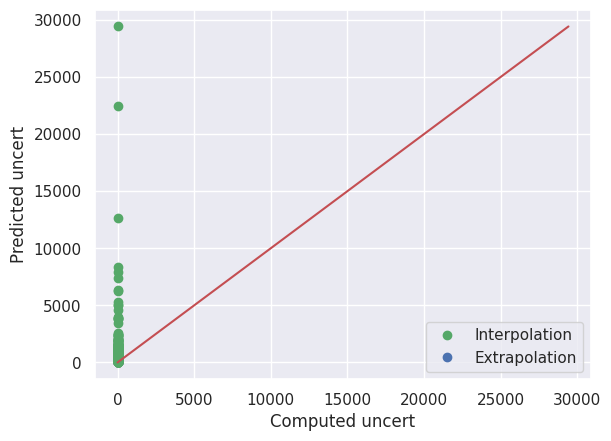

In [9]:
gt_uncertainties   = np.abs(ground_truths - predictions)
pred_uncertainties = np.abs(uncertainties)

xpred = gt_uncertainties[are_interpolated]
ypred = pred_uncertainties[are_interpolated]
plt.plot(xpred, ypred, 'og', label='Interpolation')

xpred = gt_uncertainties[~are_interpolated]
ypred = pred_uncertainties[~are_interpolated]
plt.plot(xpred, ypred, 'ob', label='Extrapolation')

_min_, _max_ = cld.get_min_max([gt_uncertainties, pred_uncertainties])
plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.xlabel(r'Computed uncert')
plt.ylabel(r'Predicted uncert')
plt.legend(loc='best')
plt.savefig(f'{t_folder}/UQ-values-comparison.pdf', dpi=50, bbox_inches='tight')
plt.show()